# Machine Learning using the SAS Viya Workbench Python API

We start by downloading some sample data that we will use to illustrate the machine learning Python APIs

In [1]:
import requests

# File path and name
file_path = r"/workspaces/myfolder/MachineLearning/hmeq.csv"
 
# Specify the URL of the CSV file
url = r"https://support.sas.com/documentation/onlinedoc/viya/exampledatasets/hmeq.csv"
 
# Download the and save CSV file to Workbench
response = requests.get(url)
with open(file_path, 'wb') as f:
    f.write(response.content)
    print(f'File downloaded:{file_path}')

File downloaded:/workspaces/myfolder/MachineLearning/hmeq.csv


Next we read the CSV containing the data into a Pandas dataframe in Python

In [2]:
import pandas as pd

hmeq_df = pd.read_csv(r"/workspaces/myfolder/MachineLearning/hmeq.csv")

Let's briefly explore the data before we start building machine learning models

In [3]:
hmeq_df.head(10)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
6,1,1800,48649.0,57037.0,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,NaN
7,1,1800,28502.0,43034.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
8,1,2000,32700.0,46740.0,HomeImp,Other,3.0,0.0,2.0,216.933333,1.0,12.0,NaN
9,1,2000,NaN,62250.0,HomeImp,Sales,16.0,0.0,0.0,115.800000,0.0,13.0,NaN


We must perform some data preprocessing to prepare this data for machine learning:

- A partition must be created to separate training and validation data
- Missing values must be imputed
- Useful input variables must be selected (the target is BAD)

In [4]:
#We use sklearn to partition the data into training and validation data
from sklearn.model_selection import train_test_split

X = hmeq_df.drop('BAD', axis=1)
y = hmeq_df['BAD']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=919)

print("Training data shape:", X_train.shape, "\n" + "Validation data shape:", X_valid.shape)

Training data shape: (4172, 12) 
Validation data shape: (1788, 12)


In [5]:
#We use sklearn to impute missing values (using the median/mode from the training data to impute the validation data)
from sklearn.impute import SimpleImputer
import numpy as np

#Calculate the median and mode on the training data to prepare the imputer
imp_interval = SimpleImputer(missing_values=np.nan, strategy='median')
imp_interval.set_output(transform='pandas')
imp_interval = imp_interval.fit(X_train.select_dtypes(include='number'))

imp_nominal = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_nominal.set_output(transform='pandas')
imp_nominal = imp_nominal.fit(X_train.select_dtypes(include='object'))

#Apply the imputation to the training data
X_train_imp_int = imp_interval.transform(X_train.select_dtypes(include='number'))
X_train_imp_nom = imp_nominal.transform(X_train.select_dtypes(include='object'))

X_train_imp = pd.concat([X_train_imp_int, X_train_imp_nom], axis=1)

#Apply the imputation to the validation data
X_valid_imp_int = imp_interval.transform(X_valid.select_dtypes(include='number'))
X_valid_imp_nom = imp_nominal.transform(X_valid.select_dtypes(include='object'))

X_valid_imp = pd.concat([X_valid_imp_int, X_valid_imp_nom], axis=1)

print("Training data shape:", X_train_imp.shape, "\n" + "Validation data shape:", X_valid_imp.shape)

Training data shape: (4172, 12) 
Validation data shape: (1788, 12)


In [6]:
#Select useful input variables using chi-square test
from sklearn.feature_selection import SelectKBest, chi2

#Sklearn requires nominal variables to be dummy coded, for now let's skips this and just select from the interval variables

#Select variables based on the training data
selector = SelectKBest(chi2, k=8).fit(X_train_imp_int, y_train)
selector.set_output(transform="pandas")

#Apply the selection to the training and validation data
train_selected = selector.transform(X_train_imp_int)
valid_selected = selector.transform(X_valid_imp_int)

X_train_final = pd.concat([train_selected, X_train_imp_nom], axis=1)
X_valid_final = pd.concat([valid_selected, X_valid_imp_nom], axis=1)

print("Training data shape:", X_train_final.shape, "\n" + "Validation data shape:", X_valid_final.shape)

print("Selected interval features:", selector.get_feature_names_out())
print("Selected nominal features:", list(X_train_imp_nom.columns))

Training data shape: (4172, 10) 
Validation data shape: (1788, 10)
Selected interval features: ['LOAN' 'MORTDUE' 'VALUE' 'DEROG' 'DELINQ' 'CLAGE' 'NINQ' 'DEBTINC']
Selected nominal features: ['REASON', 'JOB']


Now that we have done some basic data preprocessing we are ready to start building machine learning models. There are definitely more data preprocessing steps that we can do using Python and SAS Viya Workbench (things like variable transformations or principal components analysis), but for now we will focus on the machine learning models.

In [7]:
#fit a simple logistic regression model
from sasviya.ml.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs',
                        tol=1e-4,
                        max_iter=1000)

logreg.fit(X_train_final, y_train)

LogisticRegression(tol=0.0001, solver="lbfgs", max_iter=1000)

In [8]:
type(logreg)

sasviya.ml.linear_model.logistic.LogisticRegression

In [9]:
#fit a decision tree model
from sasviya.ml.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion="chisquare",
                               max_depth=10,
                               ccp_alpha=0)

dtree.fit(X_train_final, y_train)

DecisionTreeClassifier(criterion="chisquare")

In [10]:
#fit a random forest model
from sasviya.ml.tree import ForestClassifier

forest = ForestClassifier(criterion="chisquare",
                          n_estimators=100,
                          bootstrap=0.6,
                          max_depth=7,
                          min_samples_leaf=5,
                          random_state=919)

forest.fit(X_train_final, y_train)

ForestClassifier(criterion="chisquare", max_depth=7, random_state=919)

In [11]:
#fit a tree-based gradient boosting model
from sasviya.ml.tree import GradientBoostingClassifier

gradboost = GradientBoostingClassifier(n_estimators=100,
                                       max_depth=4,
                                       min_samples_leaf=5,
                                       learning_rate=0.1,
                                       subsample=0.8,
                                       random_state=919)

gradboost.fit(X_train_final, y_train)

GradientBoostingClassifier(subsample=0.8, random_state=919)

In [12]:
#fit a support vector machine classifier
from sasviya.ml.svm import SVC

svm = SVC(C=1.0,
          kernel="rbf")

svm.fit(X_train_final, y_train)

SVC(kernel="rbf")

In [13]:
#score training and validation data using the fitted models (we can assess them separately after this)
models = ['logreg', 'dtree','forest','gradboost','svm']
train_out = dict.fromkeys(models, None)
valid_out = dict.fromkeys(models, None)

#score the training and validation data using the models, and join the predictions to the target
for model in models:
    train_out[model] = eval(model).predict_proba(X_train_final)
    train_out[model] = train_out[model].join(y_train)

    valid_out[model] = eval(model).predict_proba(X_valid_final)
    valid_out[model] = valid_out[model].join(y_valid)

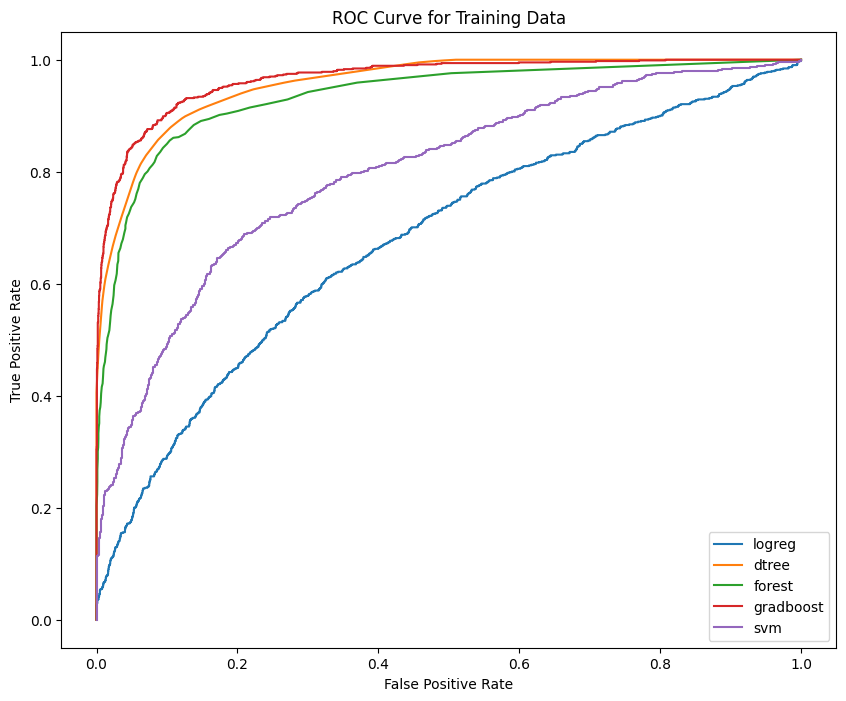

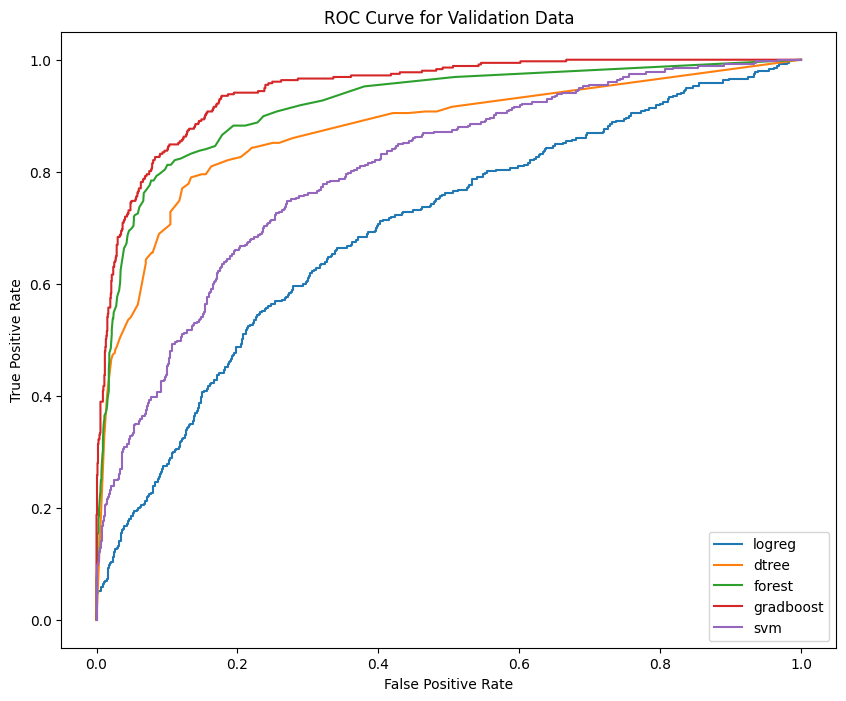

In [14]:
#plot ROC
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

train_roc = dict.fromkeys(models, None)
valid_roc = dict.fromkeys(models, None)

plt.figure(figsize=(10,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve for Training Data')
for model in models:
    train_roc[model] = roc_curve(train_out[model]['BAD'], train_out[model]['P_BAD1'], pos_label=1)
    plt.plot(train_roc[model][0], train_roc[model][1])
plt.legend(models)

plt.figure(figsize=(10,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve for Validation Data')
for model in models:
    valid_roc[model] = roc_curve(valid_out[model]['BAD'], valid_out[model]['P_BAD1'], pos_label=1)
    plt.plot(valid_roc[model][0], valid_roc[model][1])
plt.legend(models);

In [15]:
#Calculate misclassification for 'champion' model on validation data
from sklearn.metrics import accuracy_score

cutoff = 0.5
valid_preds = [1 if valid_out['gradboost']['P_BAD1'][elem] > cutoff else 0 for elem in valid_out['gradboost'].index]

print('Misclassification Rate on Validation Data for Gradient Boosting at',cutoff,'cutoff:', 1-accuracy_score(valid_out['gradboost']['BAD'], valid_preds))

Misclassification Rate on Validation Data for Gradient Boosting at 0.5 cutoff: 0.09060402684563762
